<a href="https://colab.research.google.com/github/igorfnogueira/ProjetoMachineLearning/blob/main/Projeto_Final_do_Bootcamp_CDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório

##Relatório de Análise e Modelagem para Manutenção Preditiva

### 1. Preparação e Limpeza dos Dados
O projeto foi iniciado com a carga e exploração do dataset, focando na consistência e qualidade dos dados antes da modelagem.  
- Identificação e Tratamento de Inconsistências: Foram identificados valores de falha com diferentes grafias ('sim', 'Sim', 'True') que foram padronizados para 1, e valores como 'não', 'Não', 'False' para 0. Valores anômalos como '-' foram mapeados para 0, sob a premissa inicial de ausência de falha.  
- Tratamento de Nulos e Anomalias Físicas: Valores negativos nas colunas de temperatura (em Kelvin) foram removidos, por serem medições fisicamente impossíveis. Após essa etapa, as colunas binárias de falha foram convertidas para o tipo int.  
- Gestão de Outliers e Sinais Operacionais: Uma análise detalhada revelou que os outliers e valores negativos em colunas como velocidade_rotacional e desgaste_da_ferramenta não eram erros. A decisão de manter esses dados foi tomada e validada nos resultados do modelo, que se mostrou superior ao ser treinado com essa informação.  

### 2. Análise Exploratória e Visualização
- Estatísticas Descritivas: Foram calculadas e exibidas estatísticas como média, mediana, moda e desvio padrão para as colunas numéricas, oferecendo uma visão geral da distribuição dos dados.  
- Análise de Relações: Através da visualização com boxplots comparando os atributos dos sensores com as falhas, foram obtidos insights cruciais. Por exemplo, a desgaste_da_ferramenta foi identificada como um forte preditor para a falha FDF, e o torque e o desgaste_da_ferramenta se destacaram como os principais para a FTE.  

### 3. Metodologia de Modelagem e Treinamento
- Estratégia de Classificação: Foi adotada uma abordagem de classificação multi-rótulo, onde 5 modelos foram treinados de forma independente, um para cada tipo de falha.  
- Pipeline de Pré-processamento: Um pipeline robusto com ColumnTransformer foi utilizado para automatizar as etapas de pré-processamento. Ele foi configurado para imputar valores nulos nas colunas numéricas com a mediana e escaloná-las com MinMaxScaler, além de aplicar OneHotEncoder nas colunas categóricas.  
- A escolha dos modelos Random Forest e Gradient Boosting foi a melhor para o projeto porque eles são perfeitamente adequados para dados tabulares e atende as necessidades:  

  - Alta Precisão: Eles são muito poderosos e, na maioria dos casos, alcançam os melhores resultados com dados estruturados como os seus.

  - Insights para o Negócio: Ambos os modelos podem fornecer a importância das características, o que é essencial para que a empresa entenda quais sensores são os principais causadores de falhas.

  - Robustez: Eles lidam bem com outliers e dados imperfeitos, o que simplifica o processo de limpeza e torna o modelo mais confiável.  
- Seleção de Modelos: Os modelos RandomForestClassifier e GradientBoostingClassifier foram testados para cada falha. A decisão de qual modelo usar foi baseada no melhor desempenho obtido para cada tipo de falha.  
- Otimização de Hiperparâmetros: Foi utilizado o RandomizedSearchCV para otimizar os hiperparâmetros dos modelos, buscando a melhor combinação de configurações para maximizar a performance em cada falha.  
- Otimização para Classes Desbalanceadas: Para a falha FA (Falha Aleatória), o SMOTE foi aplicado para balancear o conjunto de treino. No entanto, apesar aplicação do SMOTE o modelo falhou em conseguir bons resultados nesse tipo de falha.  
### 4. Resultados e Conclusão
- RandomForest: Obteve o melhor desempenho para as falhas FDF, FP e FA.  
- Gradient Boosting: Foi o modelo com melhor resultado para as falhas FDC e FTE.  
- Validação da Hipótese de Outliers: A hipótese de manter outliers negativos em velocidade_rotacional e desgaste_da_ferramenta foi validada pelos resultados. Os modelos treinados com esses outliers tiveram resultados superiores aos modelos sem eles, confirmando que esses valores são sinais importantes e não ruído.  
- Geração de Predições: As previsões dos 5 modelos foram consolidadas em um único arquivo CSV (predictions_classes.csv), finalizando a etapa de modelagem.  
- Organização do Projeto: O código foi reestruturado em scripts Python, com a documentação adequada, para organização e fácil manutenção.  


# Import Bibliotecas

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [189]:
!pip install imbalanced-learn

#Funções

In [190]:
def mapear_erros(df, colunas_para_mapear):

  mapeamento_falhas = {
      'não': 0,
      'Não': 0,
      'sim': 1,
      'N': 0,
      'Sim': 1,
      'y': 1,
      '1': 1,
      '0': 0,
      False: 0,
      True: 1,
      'False': 0,
      'True': 1,
      'n': 0,
      'nao': 0,
      's': 1,
  }

  for coluna in colunas_para_mapear:
      # Verifica se a coluna existe antes de tentar o mapeamento
      if coluna in df.columns:
          # Aplica o mapeamento e trata possíveis NaN
          df[coluna] = df[coluna].map(mapeamento_falhas)

          # Converte a coluna para tipo numérico
          # O parâmetro 'errors=coerce' converte valores inválidos para NaN
          df[coluna] = pd.to_numeric(df[coluna], errors='coerce')
      else:
          print(f"Aviso: A coluna '{coluna}' não foi encontrada no DataFrame.")

  return df


In [191]:
def train_and_evaluate_model(df, target_column, model_type, param_distributions=None, n_iter_search=10):

    # 1. Separar features (X) e target (y)
    y = df[target_column].copy()

    X = df.drop(columns=['id', 'id_produto', target_column]).copy()

    # 2. Separar dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Identificar colunas numéricas e categóricas em X_train
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

    # 4. Identificar colunas numéricas com valores nulos em X_train para imputação
    numerical_cols_with_missing = X_train[numerical_cols].columns[X_train[numerical_cols].isnull().any()].tolist()
    numerical_cols_no_missing = [col for col in numerical_cols if col not in numerical_cols_with_missing]


    # 5. Definir o pré-processamento usando ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_impute_scale', Pipeline([
                ('imputador', SimpleImputer(strategy='median')),
                ('escalador', MinMaxScaler())
            ]), numerical_cols_with_missing),
            ('num_scale', MinMaxScaler(), numerical_cols_no_missing),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Aplicar pré-processamento nos conjuntos de treino e teste
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar SMOTE apenas para 'FA (Falha Aleatoria)'
    if target_column == 'FA (Falha Aleatoria)':
        print(f"Aplicando SMOTE para {target_column}...")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42)
        X_train_final, y_train_final = smote.fit_resample(X_train_processed, y_train)
    else:
        X_train_final = X_train_processed
        y_train_final = y_train


    # 6. Criar o pipeline do modelo com o classificador (pré-processamento já foi feito antes do SMOTE)
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state=42)
    else:
        print(f"Tipo de modelo inválido: {model_type}")
        return None, None, None

    # O pipeline agora contém apenas o classificador, pois o pré-processamento é feito antes do SMOTE
    model_pipeline = Pipeline(steps=[
        ('classifier', model)
    ])

    # 7. Executar RandomizedSearchCV se distribuições de parâmetros forem fornecidas
    if param_distributions:
        print(f"Executando RandomizedSearchCV para {target_column} com {model_type}...")
        random_search = RandomizedSearchCV(
            model_pipeline,
            param_distributions=param_distributions,
            n_iter=n_iter_search,
            cv=5, # Validação cruzada de 5 folds
            scoring='f1', # Usando F1-score como métrica de avaliação
            random_state=42,
            n_jobs=-1 # Usar todos os núcleos disponíveis
        )
        # Ajustar RandomizedSearchCV nos dados reamostrados pelo SMOTE, se aplicável, caso contrário, nos dados processados
        random_search.fit(X_train_final, y_train_final)

        print("Melhores parâmetros encontrados:")
        print(random_search.best_params_)
        print(f"Melhor score de validação cruzada: {random_search.best_score_:.4f}")

        # Usar o melhor estimador para predição e avaliação
        best_pipeline = random_search.best_estimator_
    else:
        print(f"Treinando {model_type} para {target_column} sem ajuste de hiperparâmetros...")
        # Ajustar o pipeline nos dados reamostrados pelo SMOTE, se aplicável, caso contrário, nos dados processados
        model_pipeline.fit(X_train_final, y_train_final)
        best_pipeline = model_pipeline


    # 8. Fazer previsões e avaliar o modelo
    y_pred = best_pipeline.predict(X_test_processed) # Predizer no conjunto de teste original (não reamostrado pelo SMOTE)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # Gerar e exibir a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão para '{target_column}' - {model_type} (Ajustado)" if param_distributions else f"Matriz de Confusão para '{target_column}' - {model_type}")
    plt.tight_layout()
    plt.show()

    # Retornar o melhor pipeline, relatório e previsões
    return best_pipeline, report, y_pred

# Main

In [192]:
df_original = pd.read_csv("/content/data/bootcamp_train.csv")

In [193]:
df_original.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


In [194]:
df_original.shape

(35260, 15)

In [195]:
df_original[df_original.duplicated(keep=False)]


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)


In [196]:
df_original.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_ar,616
temperatura_processo,599
umidade_relativa,0
velocidade_rotacional,751
torque,623
desgaste_da_ferramenta,952
falha_maquina,0


In [197]:
linhas_com_nulo = df_original.isnull().any(axis=1).sum()
print(f"{linhas_com_nulo} linhas com valor null.")

3401 linhas com valor null.


In [198]:
df_original.nunique()

,0
id,35260
id_produto,9708
tipo,3
temperatura_ar,94
temperatura_processo,83
umidade_relativa,36
velocidade_rotacional,916
torque,579
desgaste_da_ferramenta,247
falha_maquina,8


In [199]:
df_original['falha_maquina'].unique()

array(['não', 'Não', 'sim', 'N', '0', 'Sim', 'y', '1'], dtype=object)

In [200]:
df_original['FDF (Falha Desgaste Ferramenta)'].unique()

array(['False', 'N', '0', 'True', '-', '1'], dtype=object)

In [201]:
df_original['FDC (Falha Dissipacao Calor)'].unique()

array(['False', 'nao', '0', 'True', 'y', '1'], dtype=object)

In [202]:
df_original['FP (Falha Potencia)'].unique()

array(['Não', 'não', 'Sim', 'N', '0', 'sim', '1', 'y'], dtype=object)

In [203]:
df_original['FTE (Falha Tensao Excessiva)'].unique()

array([False,  True])

In [204]:
df_original['FA (Falha Aleatoria)'].unique()

array(['Não', 'não', '0', '-', 'Sim', 'sim', '1'], dtype=object)

In [205]:
contagem_direta = (df_original['FA (Falha Aleatoria)'] == '-').sum()

print(f"O valor '-' aparece {contagem_direta} vezes (contagem direta).")

O valor '-' aparece 70 vezes (contagem direta).


In [206]:
contagem_direta = (df_original['FDF (Falha Desgaste Ferramenta)'] == '-').sum()

print(f"O valor '-' aparece {contagem_direta} vezes (contagem direta).")

O valor '-' aparece 70 vezes (contagem direta).


*Após checar quais dados precisam ser tratados, verifiquei que há poucos valores '-' (hífen) na tabela, por se tratar de uma quantidade baixa irei deixa-los com valor 0, identificando que não há erro.

In [207]:
df_processado = df_original.copy()

In [208]:
colunas_para_mapear = ['falha_maquina', 'FDF (Falha Desgaste Ferramenta)','FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)',
                       'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

df_processado = mapear_erros(df_processado, colunas_para_mapear)

In [209]:
df_processado['falha_maquina'].unique()

array([0, 1])

In [210]:
df_processado['FDF (Falha Desgaste Ferramenta)'].unique()

array([ 0.,  1., nan])

In [211]:
df_processado['FDC (Falha Dissipacao Calor)'].unique()

array([0, 1])

In [212]:
df_processado['FP (Falha Potencia)'].unique()

array([0, 1])

In [213]:
df_processado['FTE (Falha Tensao Excessiva)'].unique()

array([0, 1])

In [214]:
df_processado['FTE (Falha Tensao Excessiva)'].unique()

array([0, 1])

In [215]:
df_processado['FA (Falha Aleatoria)'].unique()

array([ 0., nan,  1.])

In [216]:
df_processado.dtypes

,0
id,int64
id_produto,object
tipo,object
temperatura_ar,float64
temperatura_processo,float64
umidade_relativa,float64
velocidade_rotacional,float64
torque,float64
desgaste_da_ferramenta,float64
falha_maquina,int64


In [217]:
df_processado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_ar,616
temperatura_processo,599
umidade_relativa,0
velocidade_rotacional,751
torque,623
desgaste_da_ferramenta,952
falha_maquina,0


In [218]:
df_processado['FDF (Falha Desgaste Ferramenta)'] = df_processado['FDF (Falha Desgaste Ferramenta)'].fillna(0)

In [219]:
df_processado['FA (Falha Aleatoria)'] = df_processado['FA (Falha Aleatoria)'].fillna(0)

In [220]:
df_processado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_ar,616
temperatura_processo,599
umidade_relativa,0
velocidade_rotacional,751
torque,623
desgaste_da_ferramenta,952
falha_maquina,0


In [221]:
df_processado = df_processado.dropna(subset=['FDF (Falha Desgaste Ferramenta)'])

In [222]:
df_processado = df_processado.dropna(subset=['FA (Falha Aleatoria)'])

In [223]:
df_processado['FDF (Falha Desgaste Ferramenta)'] = df_processado ['FDF (Falha Desgaste Ferramenta)'].astype(int)

In [224]:
df_processado['FA (Falha Aleatoria)'] = df_processado ['FA (Falha Aleatoria)'].astype(int)

In [225]:
df_processado.isnull().sum()

,0
id,0
id_produto,0
tipo,0
temperatura_ar,616
temperatura_processo,599
umidade_relativa,0
velocidade_rotacional,751
torque,623
desgaste_da_ferramenta,952
falha_maquina,0


In [226]:
df_processado.dtypes

,0
id,int64
id_produto,object
tipo,object
temperatura_ar,float64
temperatura_processo,float64
umidade_relativa,float64
velocidade_rotacional,float64
torque,float64
desgaste_da_ferramenta,float64
falha_maquina,int64


## Gráficos e Estatísticas antes do tratamento

### Temperatura Ar

In [227]:
media_temperatura_ar = df_processado["temperatura_ar"].mean()
moda_temperatura_ar = df_processado["temperatura_ar"].mode()
mediana_temperatura_ar = df_processado["temperatura_ar"].median()
desvio_padrao_temperatura = df_processado["temperatura_ar"].std()

print(f"Média Temperatura Ar:\n{media_temperatura_ar:.2f}\n")
print(f"Moda Temperatura Ar:\n{moda_temperatura_ar}\n")
print(f"Mediana Temperatura Ar:\n{mediana_temperatura_ar}\n")
print(f"Desvio Temperatura Ar:\n{desvio_padrao_temperatura:.2f}\n")


Média Temperatura Ar:
269.54

Moda Temperatura Ar:
0   -36.0
Name: temperatura_ar, dtype: float64

Mediana Temperatura Ar:
299.6

Desvio Temperatura Ar:
96.34



Text(0, 0.5, 'Frequência')

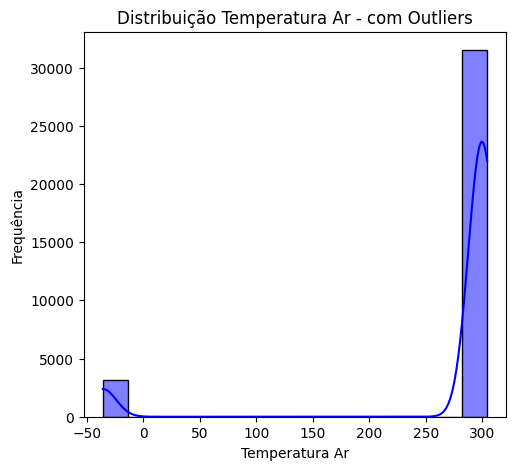

In [228]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Temperatura Ar
plt.subplot(1, 2, 1)
sns.histplot(df_processado["temperatura_ar"], bins=15, kde=True, color="blue")
plt.title("Distribuição Temperatura Ar - com Outliers")
plt.xlabel("Temperatura Ar")
plt.ylabel("Frequência")

Text(0, 0.5, 'Temperatura Ar')

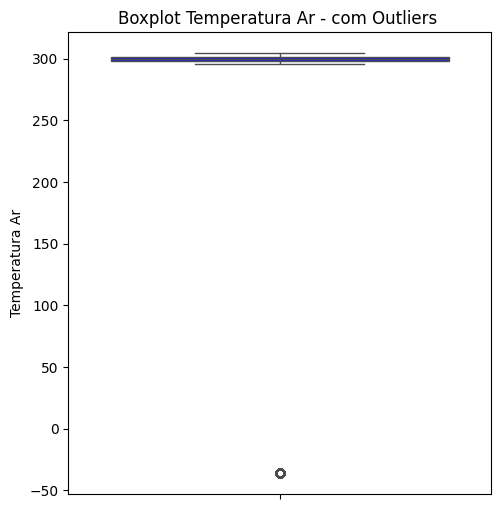

In [229]:
plt.figure(figsize=(12, 6))

# Boxplot Temperatura Ar - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["temperatura_ar"], color="blue")
plt.title("Boxplot Temperatura Ar - com Outliers ")
plt.ylabel("Temperatura Ar")

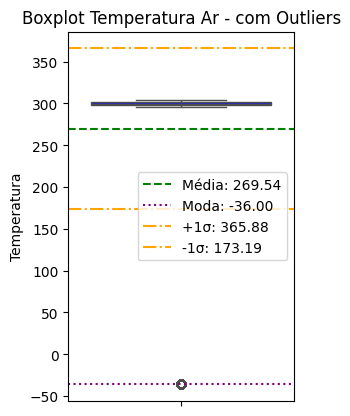

In [230]:
# Boxplot Temperatura Ar - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["temperatura_ar"], color="blue")

# Adicionando estatísticas
plt.axhline(media_temperatura_ar, color='green', linestyle='--', label=f'Média: {media_temperatura_ar:.2f}')
#Na linha de baixo pego apenas a primeira moda
plt.axhline(moda_temperatura_ar.iloc[0], color='purple', linestyle=':', label=f'Moda: {moda_temperatura_ar.iloc[0]:.2f}')

plt.axhline(media_temperatura_ar + desvio_padrao_temperatura, color='orange', linestyle='-.', label=f'+1σ: {media_temperatura_ar + desvio_padrao_temperatura:.2f}')
plt.axhline(media_temperatura_ar - desvio_padrao_temperatura, color='orange', linestyle='-.', label=f'-1σ: {media_temperatura_ar - desvio_padrao_temperatura:.2f}')

plt.title("Boxplot Temperatura Ar - com Outliers")
plt.ylabel("Temperatura")
plt.legend()

In [231]:
#como não existe graus kelvin negativo, estou substituindo todos por nan, e no pipeline será imputado a mediana
df_processado.loc[df_processado['temperatura_ar'] < 0, 'temperatura_ar'] = np.nan

In [232]:
df_processado['temperatura_ar'].isnull().sum()

np.int64(3748)

### Temperatura Processo

In [233]:
media_temperatura_processo = df_processado["temperatura_processo"].mean()
moda_temperatura_processo = df_processado["temperatura_processo"].mode()
mediana_temperatura_processo = df_processado["temperatura_processo"].median()
desvio_padrao_temperatura_processo = df_processado["temperatura_processo"].std()

print(f"Média Temperatura Processo:\n{media_temperatura_processo:.2f}\n")
print(f"Moda Temperatura Processo:\n{moda_temperatura_processo}\n")
print(f"Mediana Temperatura Processo:\n{mediana_temperatura_processo}\n")
print(f"Desvio Temperatura Processo:\n{desvio_padrao_temperatura_processo:.2f}\n")


Média Temperatura Processo:
280.46

Moda Temperatura Processo:
0   -38.0
Name: temperatura_processo, dtype: float64

Mediana Temperatura Processo:
309.8

Desvio Temperatura Processo:
96.94



Text(0, 0.5, 'Frequência')

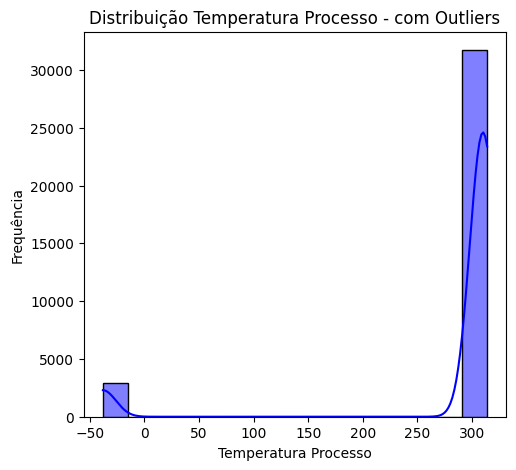

In [234]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Temperatura Processo
plt.subplot(1, 2, 1)
sns.histplot(df_processado["temperatura_processo"], bins=15, kde=True, color="blue")
plt.title("Distribuição Temperatura Processo - com Outliers")
plt.xlabel("Temperatura Processo")
plt.ylabel("Frequência")

Text(0, 0.5, 'Temperatura Processo')

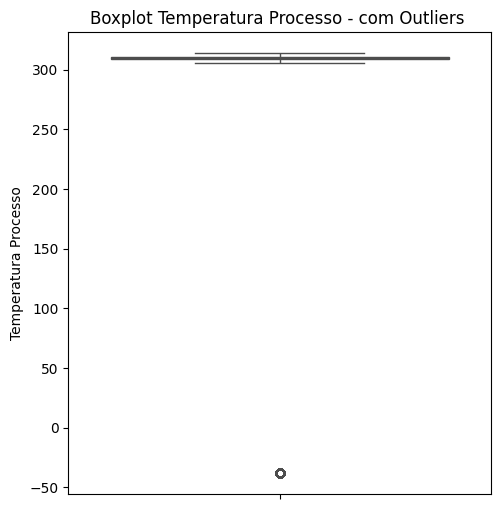

In [235]:
plt.figure(figsize=(12, 6))

# Boxplot Temperatura Processo - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["temperatura_processo"], color="blue")
plt.title("Boxplot Temperatura Processo - com Outliers ")
plt.ylabel("Temperatura Processo")

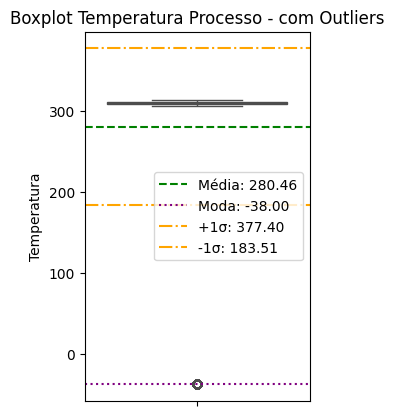

In [236]:
# Boxplot Temperatura Processo - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["temperatura_processo"], color="blue")

# Adicionando estatísticas
plt.axhline(media_temperatura_processo, color='green', linestyle='--', label=f'Média: {media_temperatura_processo:.2f}')
#Na linha de baixo pego apenas a primeira moda
plt.axhline(moda_temperatura_processo.iloc[0], color='purple', linestyle=':', label=f'Moda: {moda_temperatura_processo.iloc[0]:.2f}')

plt.axhline(media_temperatura_processo + desvio_padrao_temperatura_processo, color='orange', linestyle='-.', label=f'+1σ: {media_temperatura_processo + desvio_padrao_temperatura_processo:.2f}')
plt.axhline(media_temperatura_processo - desvio_padrao_temperatura_processo, color='orange', linestyle='-.', label=f'-1σ: {media_temperatura_processo - desvio_padrao_temperatura_processo:.2f}')

plt.title("Boxplot Temperatura Processo - com Outliers")
plt.ylabel("Temperatura")
plt.legend()

In [237]:
df_processado['temperatura_processo'].isnull().sum()

np.int64(599)

In [238]:
#como não existe graus kelvin negativo, estou substituindo todos por nan, e no pipeline será imputado a mediana
df_processado.loc[df_processado['temperatura_processo'] < 0, 'temperatura_processo'] = np.nan

In [239]:
df_processado['temperatura_processo'].isnull().sum()

np.int64(3538)

### Umidade Relativa

In [240]:
media_umidade = df_processado["umidade_relativa"].mean()
moda_umidade = df_processado["umidade_relativa"].mode()
mediana_umidade = df_processado["umidade_relativa"].median()
desvio_padrao_umidade = df_processado["umidade_relativa"].std()

print(f"Média Umidade Relativa:\n{media_umidade:.2f}\n")
print(f"Moda Umidade Relativa:\n{moda_umidade}\n")
print(f"Mediana Umidade Relativa:\n{mediana_umidade}\n")
print(f"Desvio Umidade Relativa:\n{desvio_padrao_umidade:.2f}\n")


Média Umidade Relativa:
90.00

Moda Umidade Relativa:
0    90.0
Name: umidade_relativa, dtype: float64

Mediana Umidade Relativa:
90.0

Desvio Umidade Relativa:
0.14



Text(0, 0.5, 'Frequência')

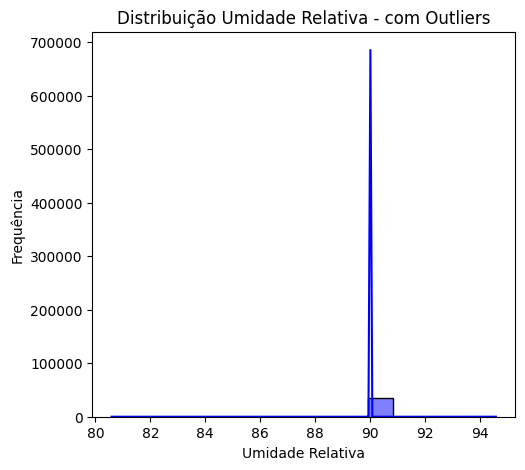

In [241]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Umidade Relativa
plt.subplot(1, 2, 1)
sns.histplot(df_processado["umidade_relativa"], bins=15, kde=True, color="blue")
plt.title("Distribuição Umidade Relativa - com Outliers")
plt.xlabel("Umidade Relativa")
plt.ylabel("Frequência")

Text(0, 0.5, 'Umidade Relativa')

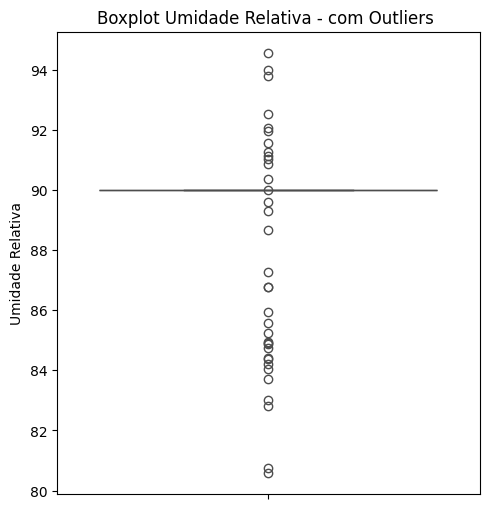

In [242]:
plt.figure(figsize=(12, 6))

# Boxplot Umidade Relativa - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["umidade_relativa"], color="blue")
plt.title("Boxplot Umidade Relativa - com Outliers ")
plt.ylabel("Umidade Relativa")

*Apesar de apontar varios outliers, a média, moda e mediana possuem o mesmo valor, e o desvio padrão é baixo. O fato de não haver uma coluna que aponte erros relacionados a umidade e esses valores que estão como "outliers" pode indicar que a umidade tenha um papel importante que pode causar outros tipos de falhas apesar de pequenas variações. Por isso irei manter os "outliers" para testar o algoritmo de machine learning, caso veja necessidade se houver resultados ruins, faço um novo treinamento sem esses "outliers"*

### Velocidade Rotacional

In [243]:
media_velocidade = df_processado["velocidade_rotacional"].mean()
moda_velocidade = df_processado["velocidade_rotacional"].mode()
mediana_velocidade = df_processado["velocidade_rotacional"].median()
desvio_padrao_velocidade = df_processado["velocidade_rotacional"].std()

print(f"Média Velocidade Rotacional:\n{media_velocidade:.2f}\n")
print(f"Moda Velocidade Rotacional:\n{moda_velocidade}\n")
print(f"Mediana Velocidade Rotacional:\n{mediana_velocidade}\n")
print(f"Desvio Velocidade Rotacional:\n{desvio_padrao_velocidade:.2f}\n")


Média Velocidade Rotacional:
1380.19

Moda Velocidade Rotacional:
0   -161.0
Name: velocidade_rotacional, dtype: float64

Mediana Velocidade Rotacional:
1483.0

Desvio Velocidade Rotacional:
494.10



Text(0, 0.5, 'Frequência')

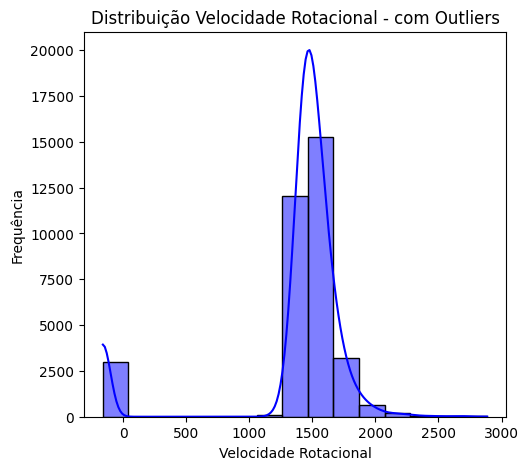

In [244]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Velocidade Rotacional
plt.subplot(1, 2, 1)
sns.histplot(df_processado["velocidade_rotacional"], bins=15, kde=True, color="blue")
plt.title("Distribuição Velocidade Rotacional - com Outliers")
plt.xlabel("Velocidade Rotacional")
plt.ylabel("Frequência")

Text(0, 0.5, 'Velocidade Rotacional')

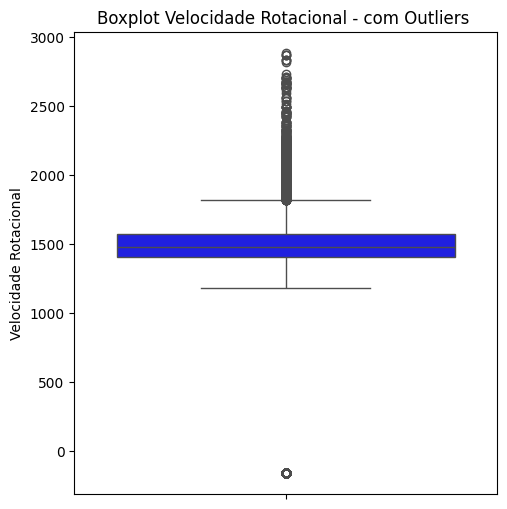

In [245]:
plt.figure(figsize=(12, 6))

# Boxplot Velocidade Rotacional - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["velocidade_rotacional"], color="blue")
plt.title("Boxplot Velocidade Rotacional - com Outliers ")
plt.ylabel("Velocidade Rotacional")

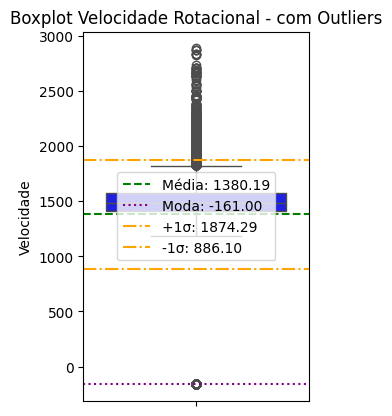

In [246]:
# Boxplot Velocidade Rotacional - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["velocidade_rotacional"], color="blue")

# Adicionando estatísticas
plt.axhline(media_velocidade, color='green', linestyle='--', label=f'Média: {media_velocidade:.2f}')
#Na linha de baixo pego apenas a primeira moda
plt.axhline(moda_velocidade.iloc[0], color='purple', linestyle=':', label=f'Moda: {moda_velocidade.iloc[0]:.2f}')

plt.axhline(media_velocidade + desvio_padrao_velocidade, color='orange', linestyle='-.', label=f'+1σ: {media_velocidade + desvio_padrao_velocidade:.2f}')
plt.axhline(media_velocidade - desvio_padrao_velocidade, color='orange', linestyle='-.', label=f'-1σ: {media_velocidade - desvio_padrao_velocidade:.2f}')

plt.title("Boxplot Velocidade Rotacional - com Outliers")
plt.ylabel("Velocidade")
plt.legend()

*Após testar o modelo do machine learning retirando os valores negativos de Desgaste da Ferramenta e depois mantendo esses valores, notei que o resultado melhor é mantendo esse valor negativo que pode estar representando algum erro que é importante ser utilizado no processo de aprendizagem.*

### Torque

In [247]:
media_torque = df_processado["torque"].mean()
moda_torque = df_processado["torque"].mode()
mediana_torque = df_processado["torque"].median()
desvio_padrao_torque = df_processado["torque"].std()

print(f"Média Torque:\n{media_torque:.2f}\n")
print(f"Moda Torque:\n{moda_torque}\n")
print(f"Mediana Torque:\n{mediana_torque}\n")
print(f"Desvio Torque:\n{desvio_padrao_torque:.2f}\n")


Média Torque:
40.21

Moda Torque:
0    40.2
Name: torque, dtype: float64

Mediana Torque:
40.3

Desvio Torque:
8.83



Text(0, 0.5, 'Frequência')

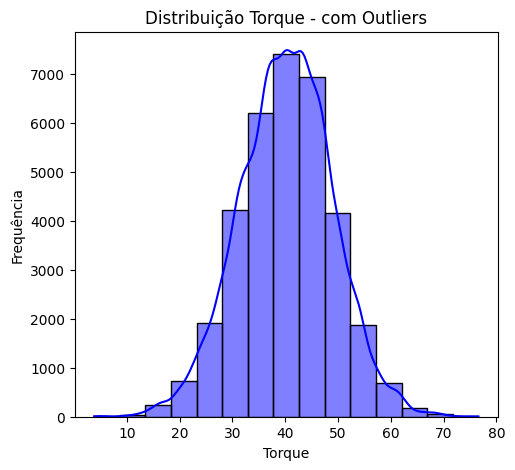

In [248]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Torque
plt.subplot(1, 2, 1)
sns.histplot(df_processado["torque"], bins=15, kde=True, color="blue")
plt.title("Distribuição Torque - com Outliers")
plt.xlabel("Torque")
plt.ylabel("Frequência")

Text(0, 0.5, 'Torque')

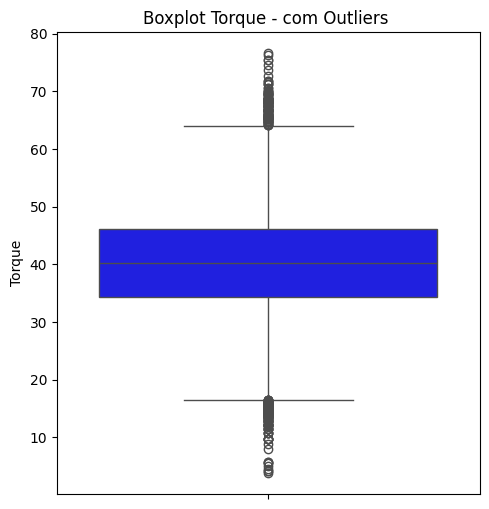

In [249]:
plt.figure(figsize=(12, 6))

# Boxplot Torque - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["torque"], color="blue")
plt.title("Boxplot Torque - com Outliers ")
plt.ylabel("Torque")

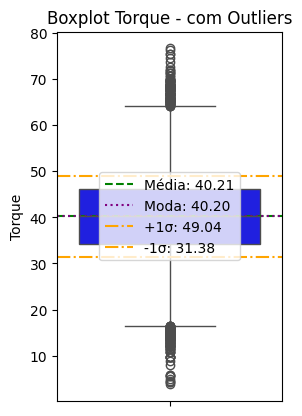

In [250]:
# Boxplot Torque - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["torque"], color="blue")

# Adicionando estatísticas
plt.axhline(media_torque, color='green', linestyle='--', label=f'Média: {media_torque:.2f}')
#Na linha de baixo pego apenas a primeira moda
plt.axhline(moda_torque.iloc[0], color='purple', linestyle=':', label=f'Moda: {moda_torque.iloc[0]:.2f}')

plt.axhline(media_torque + desvio_padrao_torque, color='orange', linestyle='-.', label=f'+1σ: {media_torque + desvio_padrao_torque:.2f}')
plt.axhline(media_torque - desvio_padrao_torque, color='orange', linestyle='-.', label=f'-1σ: {media_torque - desvio_padrao_torque:.2f}')

plt.title("Boxplot Torque - com Outliers")
plt.ylabel("Torque")
plt.legend()

### Desgaste da Ferramenta

In [251]:
media_desgaste = df_processado["desgaste_da_ferramenta"].mean()
moda_desgaste = df_processado["desgaste_da_ferramenta"].mode()
mediana_desgaste = df_processado["desgaste_da_ferramenta"].median()
desvio_padrao_desgaste = df_processado["desgaste_da_ferramenta"].std()

print(f"Média Temperatura Ar:\n{media_desgaste:.2f}\n")
print(f"Moda Temperatura Ar:\n{moda_desgaste}\n")
print(f"Mediana Temperatura Ar:\n{mediana_desgaste}\n")
print(f"Desvio Temperatura Ar:\n{desvio_padrao_desgaste:.2f}\n")


Média Temperatura Ar:
74.37

Moda Temperatura Ar:
0   -202.0
Name: desgaste_da_ferramenta, dtype: float64

Mediana Temperatura Ar:
94.0

Desvio Temperatura Ar:
110.41



Text(0, 0.5, 'Frequência')

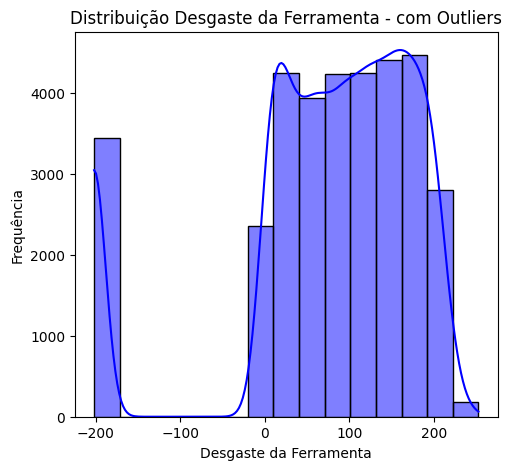

In [252]:
# Criando gráficos de distribuição com outliers
plt.figure(figsize=(12, 5))

# Histograma Desgaste da Ferramenta
plt.subplot(1, 2, 1)
sns.histplot(df_processado["desgaste_da_ferramenta"], bins=15, kde=True, color="blue")
plt.title("Distribuição Desgaste da Ferramenta - com Outliers")
plt.xlabel("Desgaste da Ferramenta")
plt.ylabel("Frequência")

Text(0, 0.5, 'Desgaste da Ferramenta')

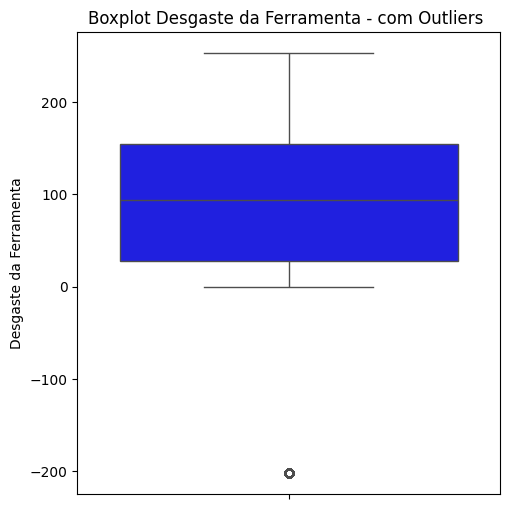

In [253]:
plt.figure(figsize=(12, 6))

# Boxplot Desgaste da Ferramenta - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["desgaste_da_ferramenta"], color="blue")
plt.title("Boxplot Desgaste da Ferramenta - com Outliers ")
plt.ylabel("Desgaste da Ferramenta")

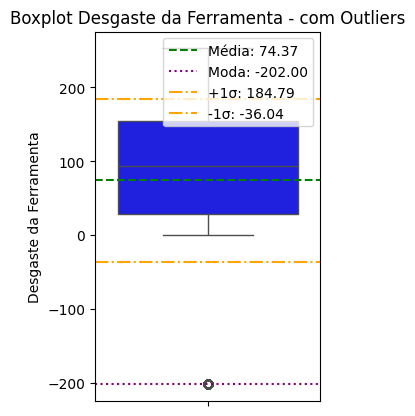

In [254]:
# Boxplot Desgaste da Ferramenta - com outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df_processado["desgaste_da_ferramenta"], color="blue")

# Adicionando estatísticas
plt.axhline(media_desgaste, color='green', linestyle='--', label=f'Média: {media_desgaste:.2f}')
#Na linha de baixo pego apenas a primeira moda
plt.axhline(moda_desgaste.iloc[0], color='purple', linestyle=':', label=f'Moda: {moda_desgaste.iloc[0]:.2f}')

plt.axhline(media_desgaste + desvio_padrao_desgaste, color='orange', linestyle='-.', label=f'+1σ: {media_desgaste + desvio_padrao_desgaste:.2f}')
plt.axhline(media_desgaste - desvio_padrao_desgaste, color='orange', linestyle='-.', label=f'-1σ: {media_desgaste - desvio_padrao_desgaste:.2f}')

plt.title("Boxplot Desgaste da Ferramenta - com Outliers")
plt.ylabel("Desgaste da Ferramenta")
plt.legend()

*Após testar o modelo do machine learning retirando os valores negativos de Desgaste da Ferramenta e depois mantendo esses valores, notei que o resultado melhor é mantendo esse valor negativo que pode estar representando algum erro que é importante ser utilizado no processo de aprendizagem.*

## Comparação de Boxplots dos sensores e falhas

### Visualizando a relação entre Features Operacionais e FDF (Falha Desgaste Ferramenta)

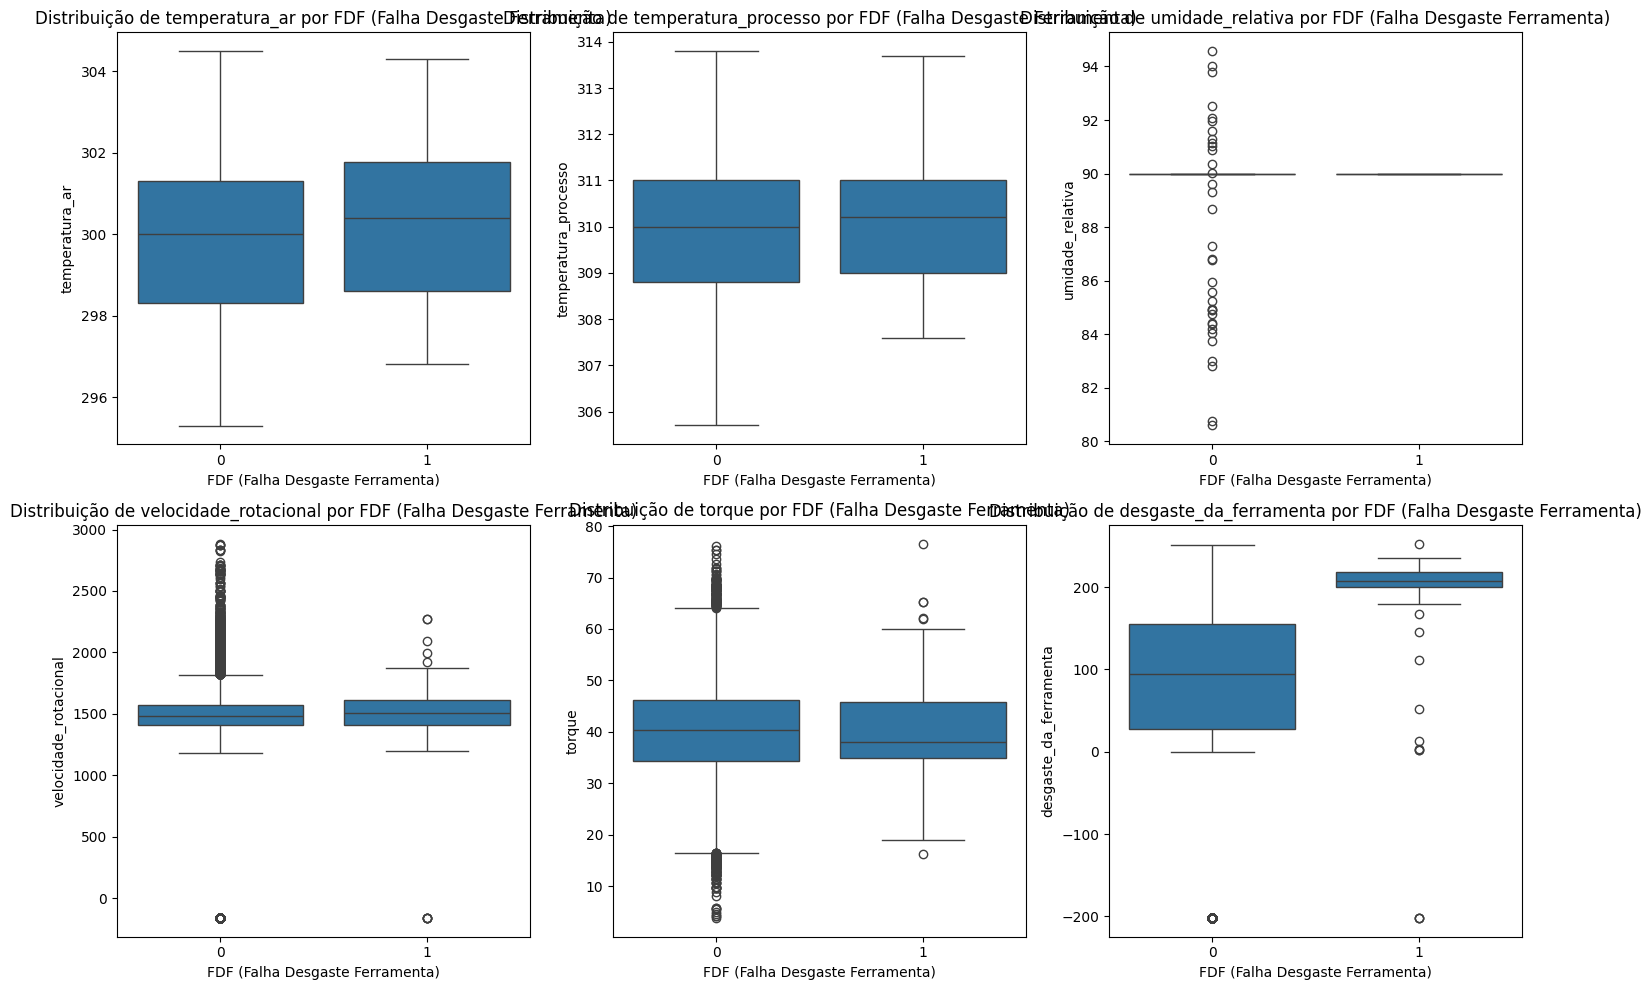

In [255]:

# Definir os atributos operacionais e a variável alvo
operational_features = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa',
                        'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
target_failure = 'FDF (Falha Desgaste Ferramenta)'

# Criar box plots para cada atributo operacional vs a falha alvo
plt.figure(figsize=(15, 10))

for i, feature in enumerate(operational_features):
    plt.subplot(2, 3, i + 1) # Ajuste o layout conforme o número de atributos
    sns.boxplot(x=target_failure, y=feature, data=df_processado)
    plt.title(f'Distribuição de {feature} por {target_failure}')
    plt.xlabel(target_failure)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Visualizando a relação entre Features Operacionais e FDC (Falha Dissipacao Calor)

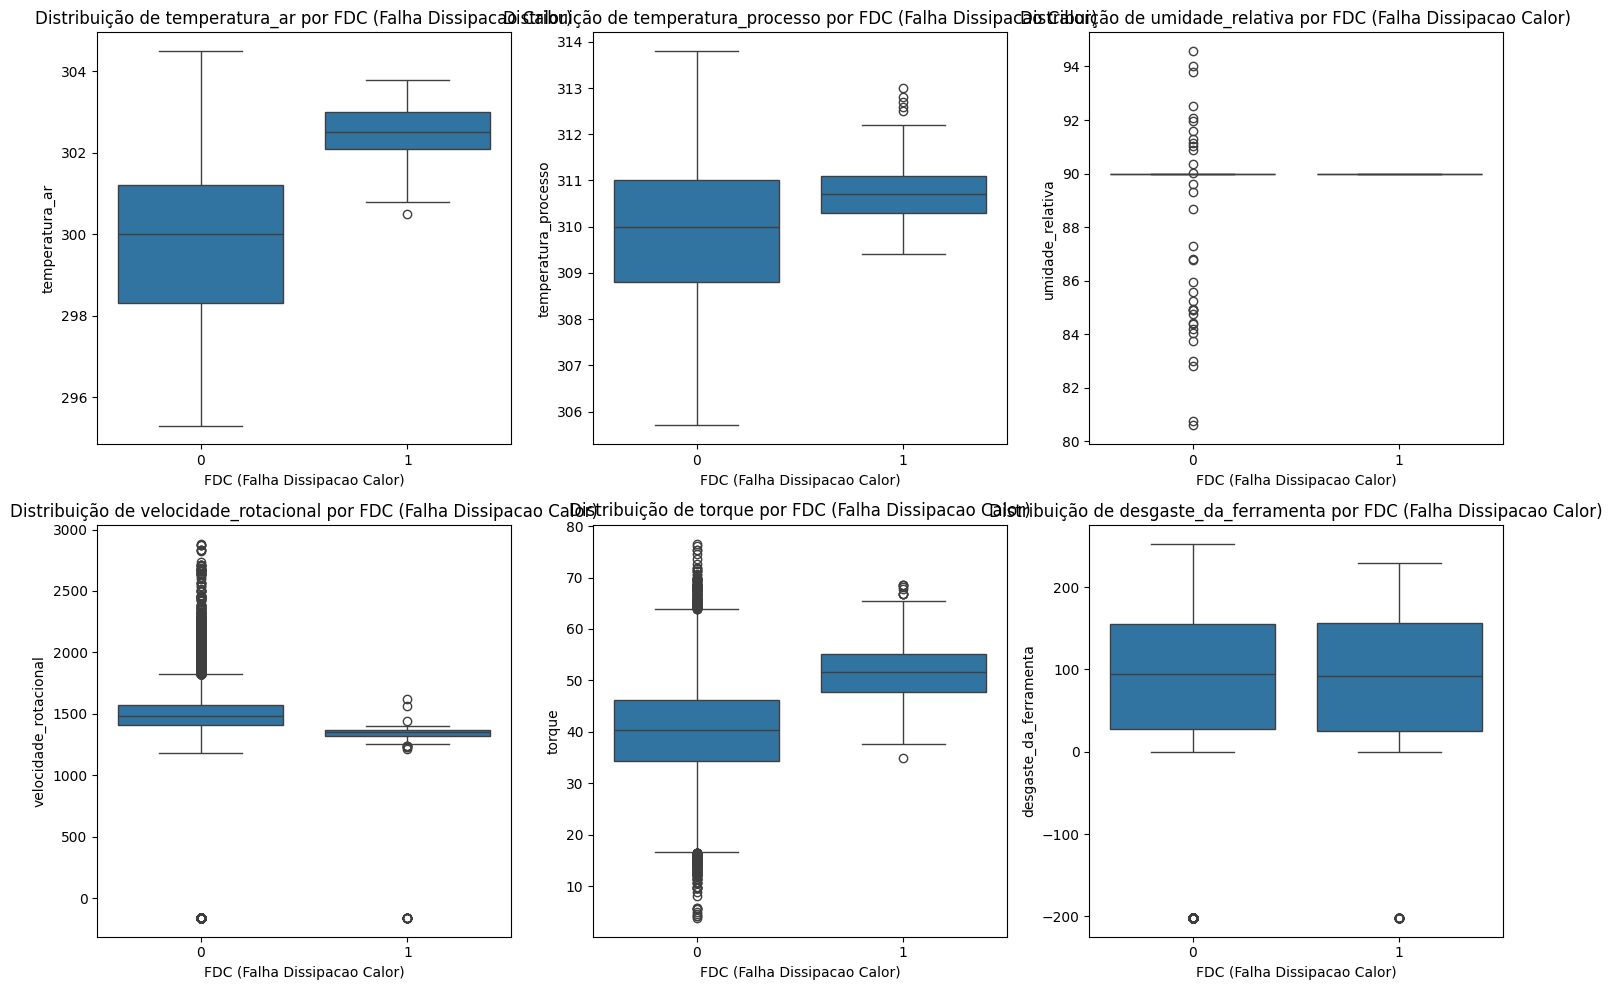

In [256]:
# Definir a variável alvo para FDC
target_failure = 'FDC (Falha Dissipacao Calor)'

# Criar box plots para cada atributo operacional vs a falha alvo
plt.figure(figsize=(15, 10))

for i, feature in enumerate(operational_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=target_failure, y=feature, data=df_processado)
    plt.title(f'Distribuição de {feature} por {target_failure}')
    plt.xlabel(target_failure)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Visualizando a relação entre Features Operacionais e FP (Falha Potencia)

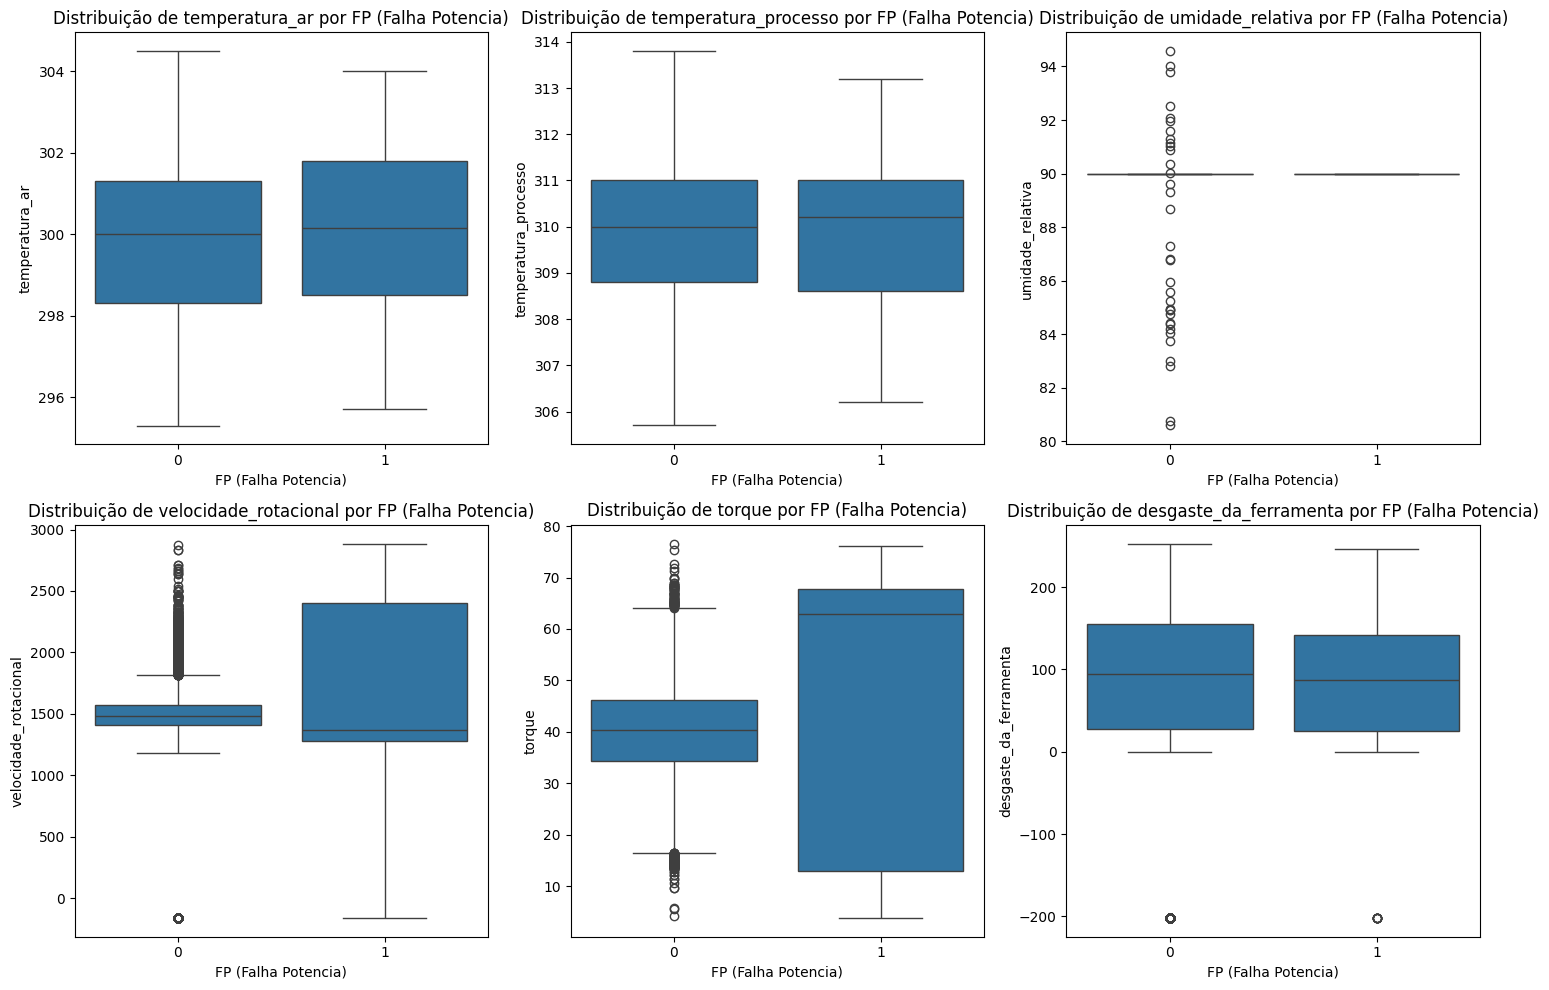

In [257]:
# Definir a variável alvo para FP
target_failure = 'FP (Falha Potencia)'

# Criar box plots para cada atributo operacional vs a falha alvo
plt.figure(figsize=(15, 10))

for i, feature in enumerate(operational_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=target_failure, y=feature, data=df_processado)
    plt.title(f'Distribuição de {feature} por {target_failure}')
    plt.xlabel(target_failure)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Visualizando a relação entre Features Operacionais e FTE (Falha Tensao Excessiva)

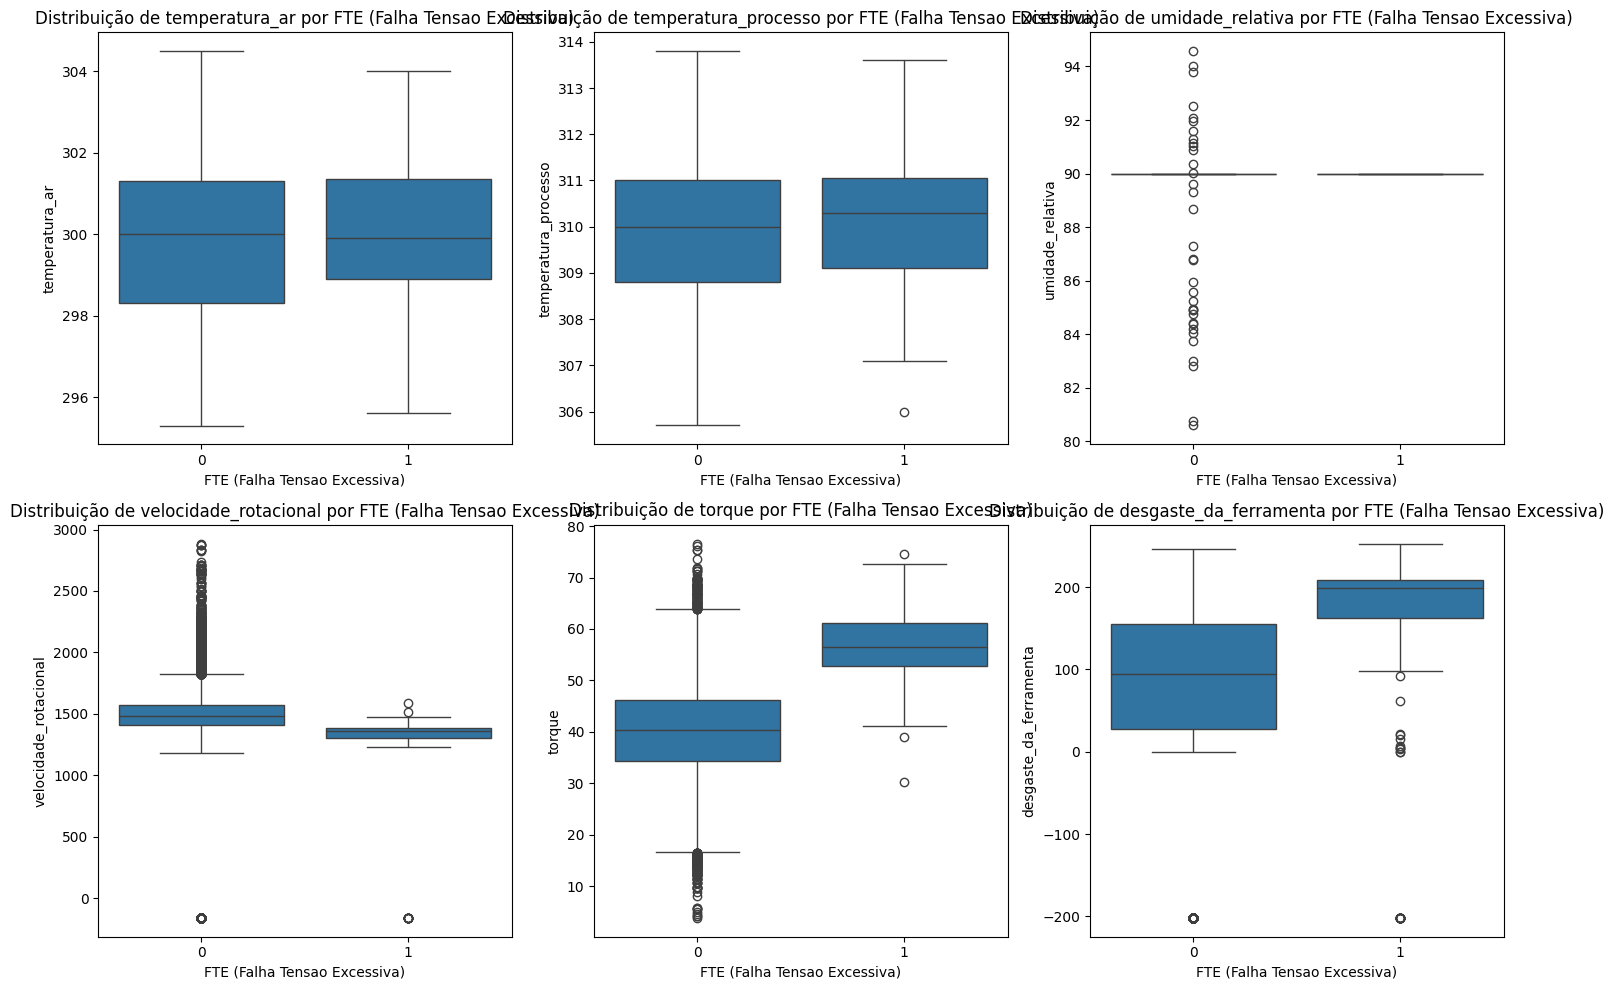

In [258]:
# Definir a variável alvo para FTE
target_failure = 'FTE (Falha Tensao Excessiva)'

# Criar box plots para cada atributo operacional vs a falha alvo
plt.figure(figsize=(15, 10))

for i, feature in enumerate(operational_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=target_failure, y=feature, data=df_processado)
    plt.title(f'Distribuição de {feature} por {target_failure}')
    plt.xlabel(target_failure)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [259]:
df_processado['torque']

,torque
0,31.1
1,53.8
2,31.1
3,33.0
4,33.9
...,...
35255,34.2
35256,36.2
35257,35.8
35258,37.3


### Visualizando a relação entre Features Operacionais e FA (Falha Aleatoria)

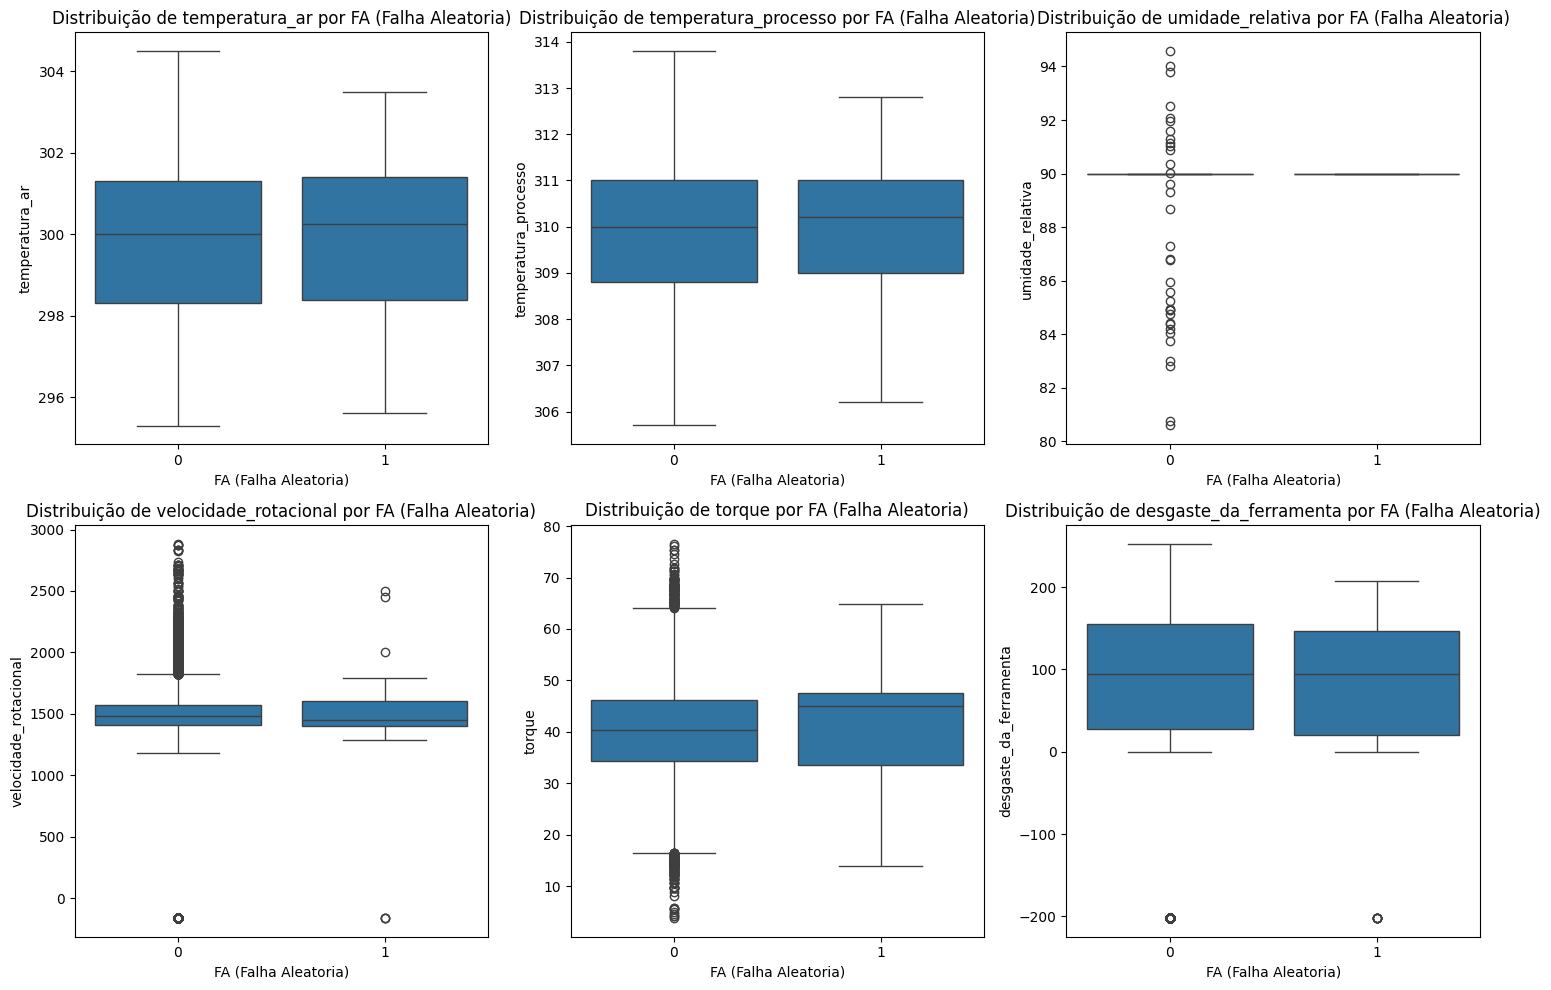

In [260]:
# Definir a variável alvo para FA
target_failure = 'FA (Falha Aleatoria)'

# Criar box plots para cada atributo operacional vs a falha alvo
plt.figure(figsize=(15, 10))

for i, feature in enumerate(operational_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=target_failure, y=feature, data=df_processado)
    plt.title(f'Distribuição de {feature} por {target_failure}')
    plt.xlabel(target_failure)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## Define Distribuição de Parâmetros



In [261]:


rf_param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__bootstrap': [True, False]
}

gb_param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__subsample': uniform(0.6, 0.4)
}

In [262]:
from scipy.stats import randint, uniform

rf_param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__bootstrap': [True, False]
}

gb_param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__subsample': uniform(0.6, 0.4)
}

## Treinando Modelos

### Modelo 1 - FDF (Falha Desgaste Ferramenta)

Executando RandomizedSearchCV para FDF (Falha Desgaste Ferramenta) com RandomForest...
Melhores parâmetros encontrados:
{'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 413}
Melhor score de validação cruzada: 0.5586
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7038
           1       0.80      0.57      0.67        14

    accuracy                           1.00      7052
   macro avg       0.90      0.79      0.83      7052
weighted avg       1.00      1.00      1.00      7052



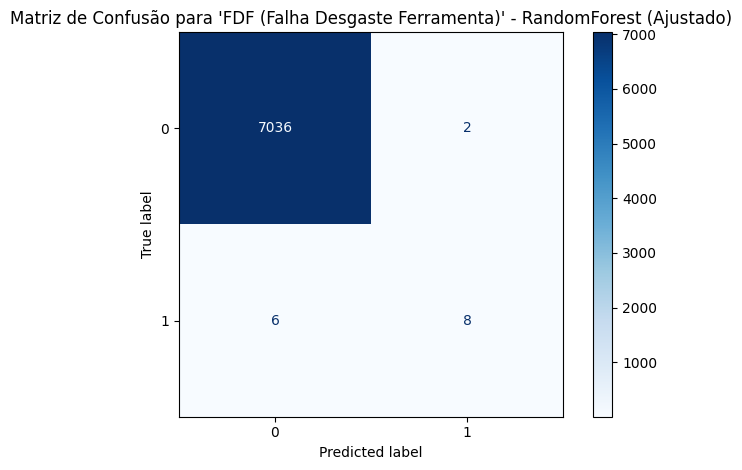

In [263]:
pipeline_fdf, report_fdf, predictions_fdf = train_and_evaluate_model(df_processado, 'FDF (Falha Desgaste Ferramenta)', 'RandomForest', param_distributions=rf_param_dist)

### Modelo 2 - FDC (Falha Dissipacao Calor)

Executando RandomizedSearchCV para FDC (Falha Dissipacao Calor) com GradientBoosting...
Melhores parâmetros encontrados:
{'classifier__learning_rate': np.float64(0.013193250444042839), 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 363, 'classifier__subsample': np.float64(0.6137554084460873)}
Melhor score de validação cruzada: 0.9042
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7007
           1       0.89      0.87      0.88        45

    accuracy                           1.00      7052
   macro avg       0.94      0.93      0.94      7052
weighted avg       1.00      1.00      1.00      7052



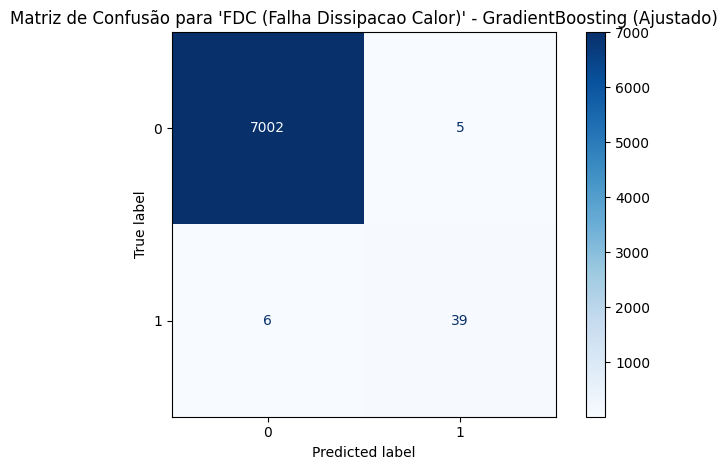

In [264]:
pipeline_FDC, report_FDC, predictions_FDC = train_and_evaluate_model(df_processado, 'FDC (Falha Dissipacao Calor)', 'GradientBoosting', param_distributions=gb_param_dist)

### Modelo 3 - FP (Falha Potencia)

Executando RandomizedSearchCV para FP (Falha Potencia) com RandomForest...
Melhores parâmetros encontrados:
{'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 413}
Melhor score de validação cruzada: 0.7817
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7027
           1       0.88      0.60      0.71        25

    accuracy                           1.00      7052
   macro avg       0.94      0.80      0.86      7052
weighted avg       1.00      1.00      1.00      7052



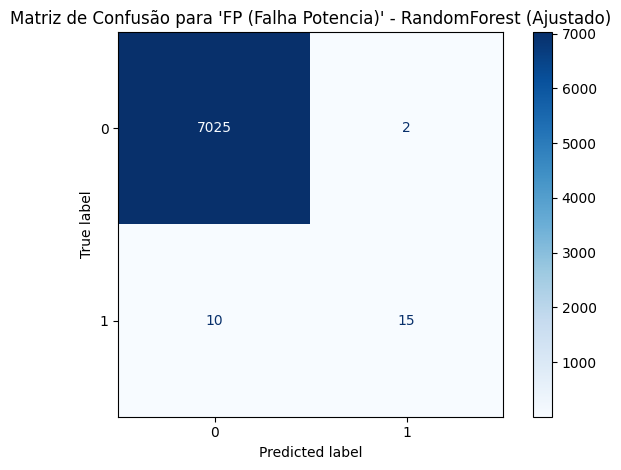

In [265]:
pipeline_FP, report_FP, predictions_FP = train_and_evaluate_model(df_processado, 'FP (Falha Potencia)', 'RandomForest', param_distributions=rf_param_dist)

### Modelo 4 - FTE (Falha Tensao Excessiva)

Executando RandomizedSearchCV para FTE (Falha Tensao Excessiva) com GradientBoosting...
Melhores parâmetros encontrados:
{'classifier__learning_rate': np.float64(0.013193250444042839), 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 363, 'classifier__subsample': np.float64(0.6137554084460873)}
Melhor score de validação cruzada: 0.7356
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7018
           1       0.94      0.85      0.89        34

    accuracy                           1.00      7052
   macro avg       0.97      0.93      0.95      7052
weighted avg       1.00      1.00      1.00      7052



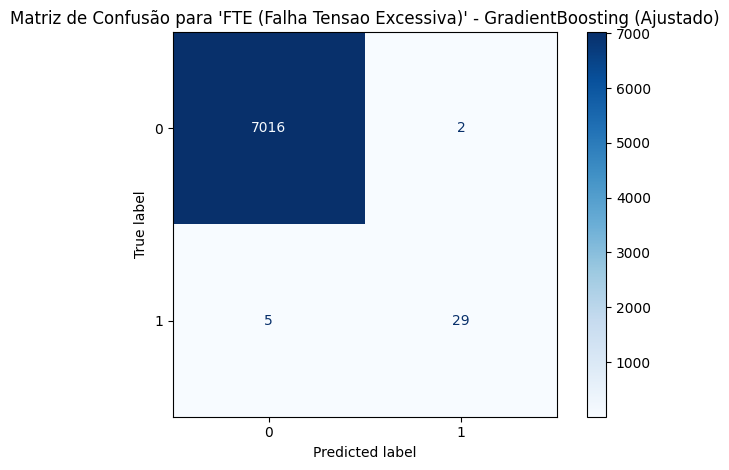

In [266]:
pipeline_FTE, report_FTE, predictions_FTE = train_and_evaluate_model(df_processado, 'FTE (Falha Tensao Excessiva)', 'GradientBoosting', param_distributions=gb_param_dist)

### Modelo 5 - FA (Falha Aleatoria)

Aplicando SMOTE para FA (Falha Aleatoria)...
Executando RandomizedSearchCV para FA (Falha Aleatoria) com RandomForest...
Melhores parâmetros encontrados:
{'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 413}
Melhor score de validação cruzada: 0.9960
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7037
           1       0.00      0.00      0.00        15

    accuracy                           0.99      7052
   macro avg       0.50      0.50      0.50      7052
weighted avg       1.00      0.99      0.99      7052



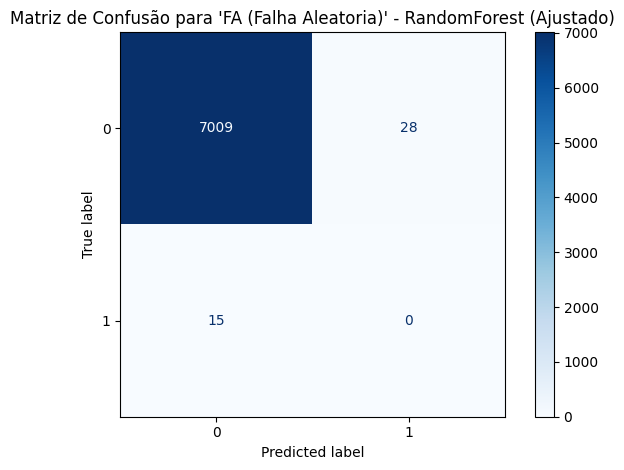

In [267]:
pipeline_FA, report_FA, predictions_FA = train_and_evaluate_model(df_processado, 'FA (Falha Aleatoria)', 'RandomForest', param_distributions=rf_param_dist)

## Gerando CSV com predições

In [268]:
# Re-executar a divisão treino/teste para obter os mesmos índices de teste
# Isso é necessário para alinhar as previsões com os IDs originais corretos
y_dummy = df_processado['FA (Falha Aleatoria)'].copy() # Usando uma das colunas alvo apenas para obter os índices da divisão
X_dummy = df_processado.drop(columns=['id', 'id_produto', 'falha_maquina',
                                      'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
                                      'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)',
                                      'FA (Falha Aleatoria)']).copy()

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=42, stratify=y_dummy)

# Obter os índices do conjunto de teste do dataframe processado
test_indices = X_test_dummy.index

# Selecionar os dados originais correspondentes aos índices do conjunto de teste para obter o 'id'
df_test_original = df_original.loc[test_indices].copy()

# Criar um dicionário com as previsões para cada tipo de falha
predictions_data = {
    'id': df_test_original['id'],
    'FDF (Falha Desgaste Ferramenta)': predictions_fdf,
    'FDC (Falha Dissipacao Calor)': predictions_FDC,
    'FP (Falha Potencia)': predictions_FP,
    'FTE (Falha Tensao Excessiva)': predictions_FTE,
    'FA (Falha Aleatoria)': predictions_FA
}

# Criar um DataFrame a partir dos dados de previsões
predictions_df = pd.DataFrame(predictions_data)

# Salvar o DataFrame em um arquivo CSV
predictions_df.to_csv('predictions_classes.csv', index=False)

print("Arquivo CSV com classes preditas gerado com sucesso: predictions_classes.csv")
display(predictions_df.head(100))

Arquivo CSV com classes preditas gerado com sucesso: predictions_classes.csv


,id,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
27997,27997,0,0,0,0,0
13636,13636,0,0,0,0,0
7506,7506,0,0,0,0,0
6165,6165,0,0,0,0,0
22428,22428,0,0,0,0,0
...,...,...,...,...,...,...
31961,31961,0,0,0,0,0
25586,25586,0,0,0,0,0
305,305,0,0,0,0,0
14621,14621,0,0,0,0,0
